In [46]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [47]:
air_passengers = pd.read_csv("./data/AirPassengers.csv", header = 0, parse_dates = [0], names = ['Month', 'Passengers'], index_col = 0)

In [50]:
log_air_passengers = np.log(air_passengers.Passengers)
log_air_passengers[1:10]

Month
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
1949-06-01    4.905275
1949-07-01    4.997212
1949-08-01    4.997212
1949-09-01    4.912655
1949-10-01    4.779123
Name: Passengers, dtype: float64

In [53]:
log_air_passengers_diff = log_air_passengers - log_air_passengers.shift()

In [54]:
log_air_passengers_diff.dropna(inplace=True)
log_air_passengers_diff[1:10]

Month
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
1949-07-01    0.091937
1949-08-01    0.000000
1949-09-01   -0.084557
1949-10-01   -0.133531
1949-11-01   -0.134733
Name: Passengers, dtype: float64

In [55]:
# Let's talk about the ARIMA model
# Auto-Regressive Integrated Moving Average
# In this case we're talking about a series with dependence among values (more natural)

In [56]:
# Nothing but a linear regression with a few times
# 1. The number of Auto-Regressive Terms (p)
# 2. The number of Moving Average Terms (q)
# 3. The number of differences taken

In [57]:
# We don't pull these out of thin air, but rather draw them from the data
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(log_air_passengers_diff.values, nlags = 20)
lag_pacf = pacf(log_air_passengers_diff.values, nlags = 20)

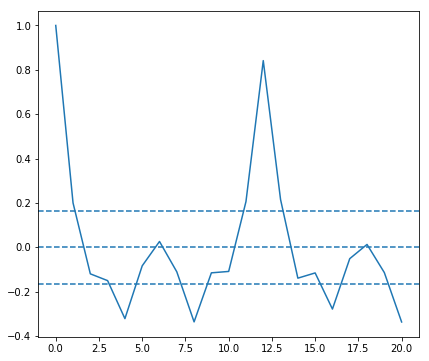

In [58]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')

In [59]:
# look at where the plot crosses the upper confidence interval for the first time
# for ACF this is 2 and gives us the p value

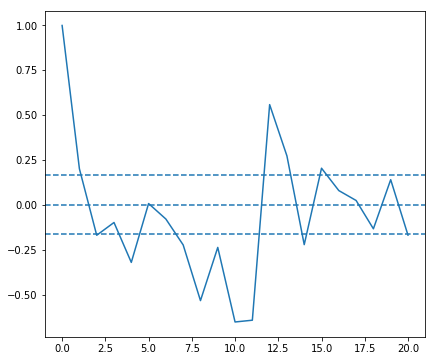

In [60]:
plt.subplot(121) 
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')

In [62]:
# look at where the plot crosses the upper confidence interval for the first time
# for PACF this is 2 and gives us the p value

In [63]:
from statsmodels.tsa.arima_model import ARIMA

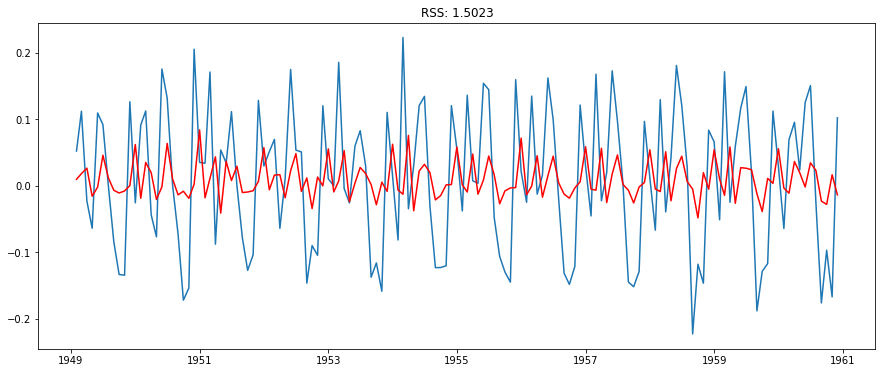

In [64]:
# AR model
model = ARIMA(log_air_passengers, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-log_air_passengers_diff)**2))

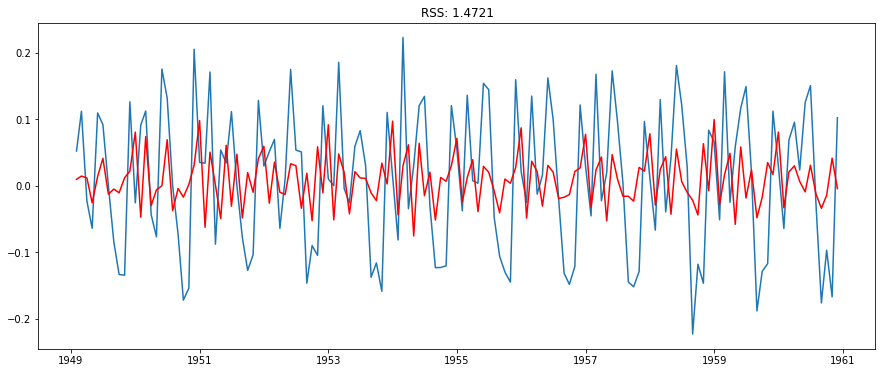

In [65]:
# MA model
model = ARIMA(log_air_passengers, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-log_air_passengers_diff)**2))

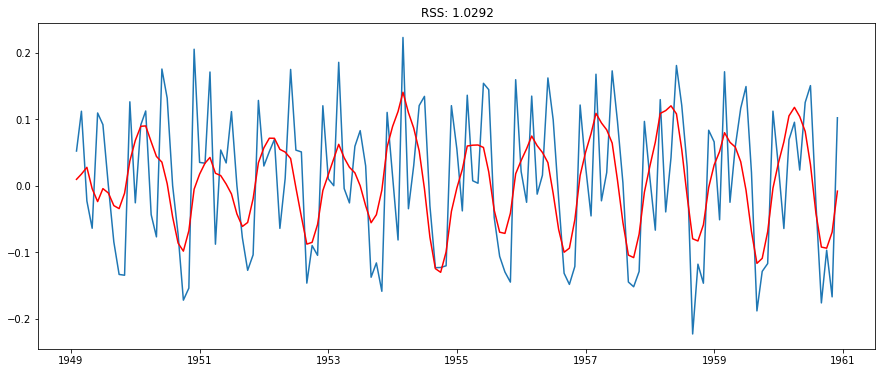

In [66]:
# ARIMA model
model = ARIMA(log_air_passengers, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-log_air_passengers_diff)**2))

In [67]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [68]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [69]:
predictions_ARIMA_log = pd.Series(log_air_passengers.ix[0], index=log_air_passengers.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

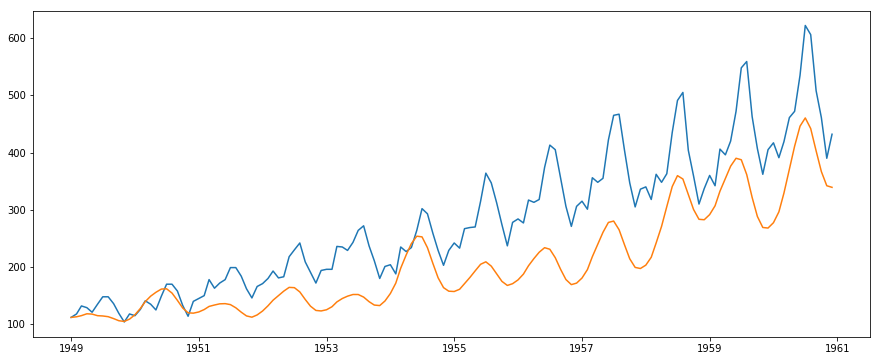

In [71]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(air_passengers)
plt.plot(predictions_ARIMA)